# Ridge regression with polynomial features of degree 2
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
import pickle
import os
import scipy.stats as st
from azure.storage.blob import BlockBlobService

In [2]:
from azureml.logging import get_azureml_logger
run_logger = get_azureml_logger()
run_logger.log('amlrealworld.timeseries.ridge-poly','true')

In [3]:
model_name = "ridge_poly2"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
ACCOUNT_NAME = "petcgexperimentstorage"
ACCOUNT_KEY = "C+ffy45PBcicHAxWiRbW9MnFR651A8xbiVe2wkyZgolznhFf70caTZmpWIJb2spV5YFl/LQB0ARUfU+AQx6w9g=="
CONTAINER_NAME = "energy-demand-demo"
block_blob_service = BlockBlobService(account_name=ACCOUNT_NAME, account_key=ACCOUNT_KEY)
train = None
list_of_blobs = block_blob_service.list_blobs(CONTAINER_NAME)
for each_blob in list_of_blobs:
    if ("part-00" in each_blob.name):
        block_blob_service.get_blob_to_path(CONTAINER_NAME, blob_name=each_blob.name, file_path='./nyc_demand.csv')
        train = pd.read_csv('./nyc_demand.csv')
        break

Create model pipeline:
- one-hot encode categorical features.
- create polynomial features of degree 2. This means that for each pair of features $(x_1, x_2)$, the output features are $(x_1, x_2, x_1^2, x_1x_2, x_2^2)$
- randomized parameter search with cross validation to find optimal values for the alpha parameter

Note - to limit the training time, the number of iterations for the randomized search has been set to 20. This should train in about 3 minutes. increasing the number of iterations will increase the likelihood of finding the optimum solution but also increase training times. 

In [4]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [5]:
cat_cols = ['hour', 'month', 'dayofweek']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)
regr = Ridge(fit_intercept=False)
poly = PolynomialFeatures(2)
tscv = TimeSeriesSplit(n_splits=3)

In [6]:
param_dist = {'alpha': st.uniform(1e-4, 5.0)}
regr_cv = RandomizedSearchCV(estimator=regr,
                            param_distributions=param_dist,
                            n_iter=20,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            cv=tscv,
                            verbose=2,
                            n_jobs=1)
regr_pipe = Pipeline([('onehot', onehot), ('poly', poly), ('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] alpha=1.68552764523 .............................................
[CV] .............................. alpha=1.68552764523, total=   1.9s
[CV] alpha=1.68552764523 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] .............................. alpha=1.68552764523, total=   2.0s
[CV] alpha=1.68552764523 .............................................
[CV] .............................. alpha=1.68552764523, total=   2.7s
[CV] alpha=1.42155109289 .............................................
[CV] .............................. alpha=1.42155109289, total=   1.0s
[CV] alpha=1.42155109289 .............................................
[CV] .............................. alpha=1.42155109289, total=   1.9s
[CV] alpha=1.42155109289 .............................................
[CV] .............................. alpha=1.42155109289, total=   3.0s
[CV] alpha=2.41877311376 .............................................
[CV] .............................. alpha=2.41877311376, total=   1.1s
[CV] alpha=2.41877311376 .............................................
[CV] .............................. alpha=2.41877311376, total=   2.8s
[CV] alpha=2.41877311376 .............................................
[CV] .

[CV] .............................. alpha=4.18060156304, total=   2.8s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.2min finished


Pipeline(steps=[('onehot', OneHotEncoder(categorical_features=[2, 3, 4], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(n_splits...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

In [7]:
model_dir = "C:/Users/nelgoh/Desktop/Resources/Petronas/energy_demand_forecast/EnergyDemandForecast/outputs/models/"
with open(os.path.join(model_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [8]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
6,2.532501,0.063337,-1247.794397,-1045.249140,0.987416,{'alpha': 0.98741563936},1,-1373.654058,-1013.610441,-1078.444286,-1077.646272,-1291.284846,-1044.490708,0.691540,0.011442,124.380510,26.148019
2,2.914692,0.088000,-1248.886785,-1040.353960,0.462957,{'alpha': 0.462956692086},2,-1375.604593,-1005.306853,-1078.426512,-1073.796626,-1292.629248,-1041.958399,1.025188,0.026989,125.203183,27.983840
4,2.924354,0.060668,-1249.441871,-1039.262038,0.364886,{'alpha': 0.364886054238},3,-1376.675366,-1003.496922,-1078.570977,-1072.883868,-1293.079270,-1041.405324,1.307769,0.008965,125.551380,28.367614
10,2.309346,0.057003,-1249.499545,-1052.469466,1.89,{'alpha': 1.88999572467},4,-1378.418572,-1026.429150,-1079.211814,-1082.923544,-1290.868249,-1048.055705,0.856980,0.005713,125.604401,23.273950
14,2.660342,0.061006,-1250.214433,-1054.007193,2.08999,{'alpha': 2.08998569757},5,-1380.238246,-1029.198233,-1079.465636,-1084.034546,-1290.939416,-1048.788801,1.061859,0.013140,126.121460,22.688896


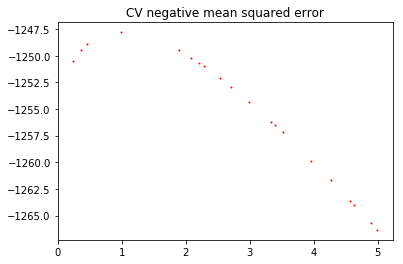

In [9]:
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], 'ro', markersize=1)
plt.title('CV negative mean squared error')
plt.show()